In [5]:
using Pkg; Pkg.add(["SCS", "Convex", "Plots"])
using LinearAlgebra
using SCS
using Convex
using Plots

  Resolving package versions...
  Installed IteratorInterfaceExtensions ─ v1.0.0
  Installed Compat ────────────────────── v3.23.0
  Installed GeometryBasics ────────────── v0.3.4
  Installed RecipesPipeline ───────────── v0.2.1
  Installed DataStructures ────────────── v0.18.8
  Installed Plots ─────────────────────── v1.9.1
  Installed SortingAlgorithms ─────────── v0.3.1
  Installed Reexport ──────────────────── v0.2.0
  Installed FixedPointNumbers ─────────── v0.8.4
  Installed LibVPX_jll ────────────────── v1.9.0+1
  Installed StaticArrays ──────────────── v1.0.1
  Installed Grisu ─────────────────────── v1.0.0
  Installed FFMPEG_jll ────────────────── v4.3.1+4
  Installed ColorTypes ────────────────── v0.10.9
  Installed Colors ────────────────────── v0.12.4
  Installed StatsBase ─────────────────── v0.33.2
  Installed OpenSSL_jll ───────────────── v1.1.1+6
  Installed Tables ────────────────────── v1.2.2
  Installed Ogg_jll ───────────────────── v1.3.4+2
  Installed libvorbis_jl

In [14]:
function packing_lp(P,epsilon,n,m)
    T = 0
    p = log(n)/epsilon
    x = ones(n)/(n^3)
    packing_values = []
    covering_values = []
    max_T = 20000
    while T < max_T
        T += 1
        y = P*x; y /= norm(y,p); y = y.^(p-1)
        packgrad = P'*y
        step = (1/p)*(ones(n)-norm(P*x,p)*packgrad) ./(ones(n)+norm(P*x,p)*packgrad)
        x =  (1 .+step) .* x
        if T%20 == 0
            push!(packing_values, norm(P*x/sum(x),p))
            push!(covering_values, minimum(packgrad))
        end
    end
    return x/sum(x), packing_values, covering_values
end

packing_lp (generic function with 1 method)

In [7]:
m = 30
n = 20
P = rand(m,n)
#n = 100000
#C = [n 0.99; 0 2]
z = Variable(n)
problem = maximize(ones(n)'*z)
problem.constraints += [z >= 0]
problem.constraints += [P*z <= 1]
solve!(problem,SCS.Optimizer(verbose=false))
P .*= ones(n)'*z.value
problem = maximize(ones(n)'*z)
problem.constraints += [z >= 0]
problem.constraints += [P*z <= 1]
solve!(problem,SCS.Optimizer(verbose=false))
maximum(P*z.value)/sum(z.value)

1.0000016417383102

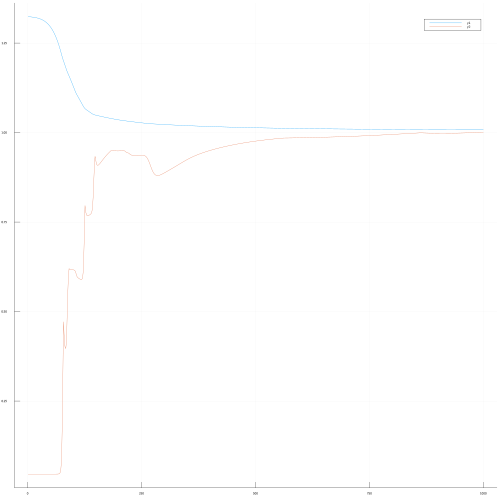

In [22]:
epsilon = 0.01
x, pack, cov = packing_lp(P,epsilon,n,m)
p=plot(pack)
plot!(cov)
plot!(size = (2000,2000))
p

In [211]:
#here be dragons
m = 30
n = 20
C = rand(m,n)
#n = 2
#M = 100000
#C = [M 0.99; 0 2]
z = Variable(n)
problem = minimize(ones(n)'*z)
problem.constraints += [z >= 0]
problem.constraints += [C*z >= 1]
solve!(problem,SCS.Optimizer(verbose=false))
C .*= ones(n)'*z.value
problem = minimize(ones(n)'*z)
problem.constraints += [z >= 0]
problem.constraints += [C*z >= 1]
solve!(problem,SCS.Optimizer(verbose=false))
minimum(C*z.value)/sum(z.value)

0.999991039366058

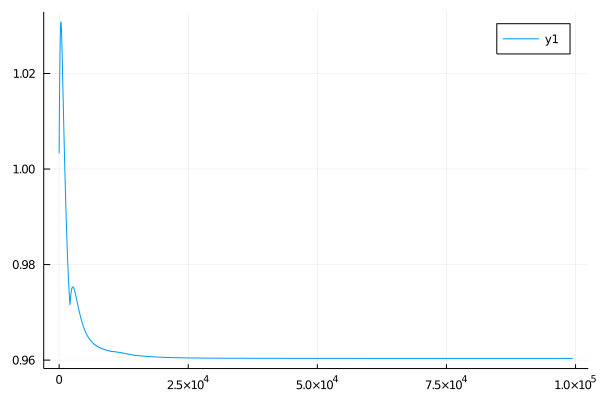

In [219]:
vec, bad_T, potential = covering_lp(C, 0.05,n,m);
plot(potential)

In [ ]:
function covering_lp(C,epsilon,n,m)
    T = 0
    p = log(n)/epsilon
    x = ones(n)/(n^3)
    y_dual = zeros(m)
    y_bad_dual = zeros(m)
    potential = []
    badT = []
    max_T = 100000
    old_obj = 1000
    while T < max_T
        T += 1
        y = C*x; y /= norm(y,-p); y = y.^(-p-1)
        covgrad = C'*y
        step = (1/p)*(sum(x)*covgrad-ones(n)) ./(ones(n)+sum(x)*covgrad)
        x =  (1 .+step) .* x
        x *= norm(C*x,-p)/sum(x)^2
        obj = sum(x)/norm(C*x,-p)
        if false #obj < 1
            println("OPT < 1")
            return x/sum(x), potential
        end
        if old_obj - obj < epsilon*(obj-1)/p
            push!(badT,T)
            push!(potential,maximum(covgrad))
            #return y, potential 
        end
        old_obj = obj
        if T == 0
            push!(potential,maximum(covgrad))
        end
    end
    return x/sum(x), badT, potential
end